In [58]:
from cartopy import geodesic as geo
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize_scalar
import shapely
import pyproj

# geoid calculator
geoid = geo.Geodesic()

# See debug plots
debug_plots = True

# Solution for Blog Post 2020-12-01
Original post [is here](https://www.aerosci.dev/2020/12/01/left-right-side-of-line.html).

## Determining Which Side of a Geodesic a Point is On

Let there be a point on the continent of North America.

In [59]:
point_off_line_deg = (-82, 38) # (lon, lat)

And, let there be a line that does _not_ go through the point.

In [60]:
# define an arbitrary line on the ellipsoid with some reasonable length
start_point_deg = (-79.0, 36)
geodesic_length_m = 250.0 * 1852.0
course_ned_deg = 335
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)
end_point_deg = (end_point_deg[0][0], end_point_deg[0][1])

Let's give ourselves a convencience function that does some plotting for us... :D

In [61]:
def create_figure(start_point_deg:tuple=None, end_point_deg:tuple=None, point_off_line_deg:tuple=None, closest_point_on_line_deg:tuple=None):
    fig_debug = go.Figure([
         go.Scattergeo(lat=[point_off_line_deg[1]], 
                       lon=[point_off_line_deg[0]], 
                       name='point_off_line'),
         go.Scattergeo(lat=[start_point_deg[1]], 
                       lon=[start_point_deg[0]], 
                       marker=dict(color='black'),
                       name='start_point'),
         go.Scattergeo(lat=[end_point_deg[1]], 
                       lon=[end_point_deg[0]], 
                       marker=dict(color='magenta'),
                       name='end_point'),
         go.Scattergeo(lat=[start_point_deg[1], end_point_deg[1]], 
                       lon=[start_point_deg[0], end_point_deg[0]], 
                       mode='lines',
                       name='line_on_ellipsoid')
    ])
    if closest_point_on_line_deg is not None:
        fig_debug.add_trace(go.Scattergeo(lat=[closest_point_on_line_deg[1]], 
                                          lon=[closest_point_on_line_deg[0]], 
                                          name='closest_point_on_line'))

    fig_debug.update_layout(geo=dict(scope='north america', lataxis_range=[30,45], lonaxis_range=[-90, -75]), height=400, width=600)
    
    return fig_debug

### Closest Point On Line Algorithm

First, find a point on the line that is nearest to `point_off_line`. There are many ways to do this; here, we use `scipy.optimize.minimize_scalar`.

In [62]:
distance_from_start_point_to_point_off_line_m = np.array(geoid.inverse(point_off_line_deg, start_point_deg))[0][0]
distance_from_end_point_to_point_off_line_m = np.array(geoid.inverse(point_off_line_deg, end_point_deg))[0][0]
y_intercept_shift = distance_from_start_point_to_point_off_line_m + (distance_from_end_point_to_point_off_line_m-distance_from_start_point_to_point_off_line_m)/2

if debug_plots:
    fig_debug = create_figure(start_point_deg=start_point_deg,
                              end_point_deg=end_point_deg,
                              point_off_line_deg=point_off_line_deg)
    
def distance_from_point_off_line(distance_from_start_point_m=0):
    b = geoid.direct(start_point_deg, course_ned_deg, distance_from_start_point_m)
    point_on_line_at_distance_deg = np.array(b)[0]
    c = geoid.inverse(point_off_line_deg, (point_on_line_at_distance_deg[0], point_on_line_at_distance_deg[1]))
    distance_from_point_off_line_m = np.array(c)[0][0]
    
    if debug_plots:
        fig_debug.add_trace(
            go.Scattergeo(lat=[point_on_line_at_distance_deg[1]], 
                       lon=[point_on_line_at_distance_deg[0]], 
                       mode='markers',
                       hovertext=f'y:{distance_from_point_off_line_m}',
                       name=f'x:{distance_from_start_point_m}')
        )
    
    return distance_from_point_off_line_m

def find_closest_point_on_line():
    # use bisection to find the closest point along the geodesic within a tolerance of 1 meters
    result = minimize_scalar(fun=distance_from_point_off_line, bounds=(0, geodesic_length_m), method='bounded', options={'xatol': 10, 'maxiter': 500, 'disp': 0})
    if not result.success:
        print(f'FAIL: {result.message}')
    distance_from_start_m = result.x
    
    # Calculate the lat/lon of this point
    b = geoid.direct(start_point_deg, course_ned_deg, distance_from_start_m)
    perpendicular_point_on_line_deg = (np.array(b)[0][0], np.array(b)[0][1])
    return perpendicular_point_on_line_deg

(-80.53354685292773, 38.573377960646326)


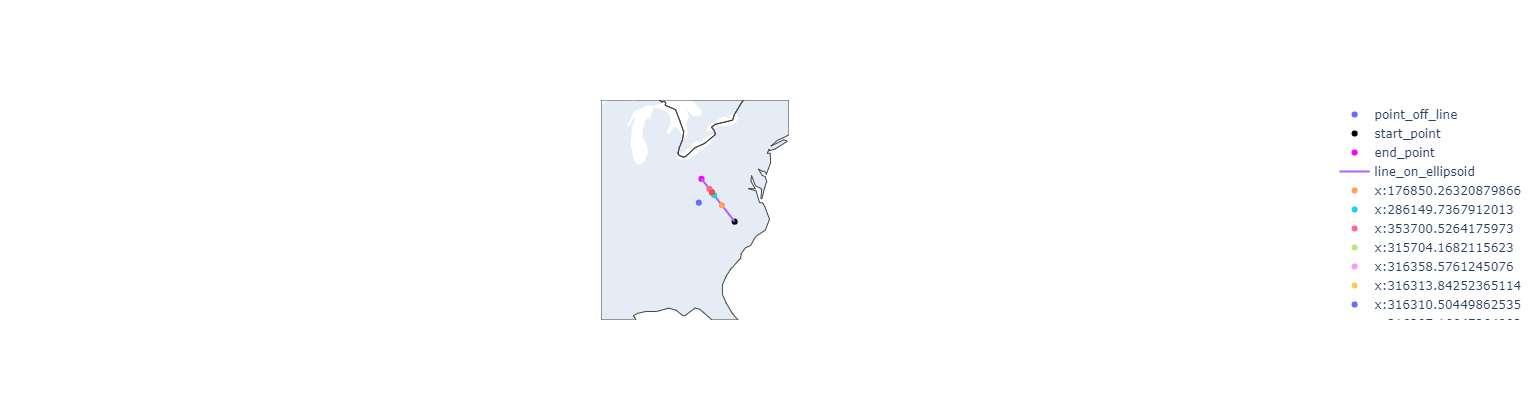

In [63]:
closest_point_on_line_deg = find_closest_point_on_line()
print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

Let's visualize this solution of the nearest point on the line. The figure above (only visible if debug plotting is turned on) shows the solution to the `find_closest_point_on_line` algorithm. The figure below shows an example geometry that we're trying to solve algorithmically. We have a line starting at `start_point` and ending at `end_point`. The point `point_off_line` is clearly to the LEFT of the line according to the implied directionality of the line. 


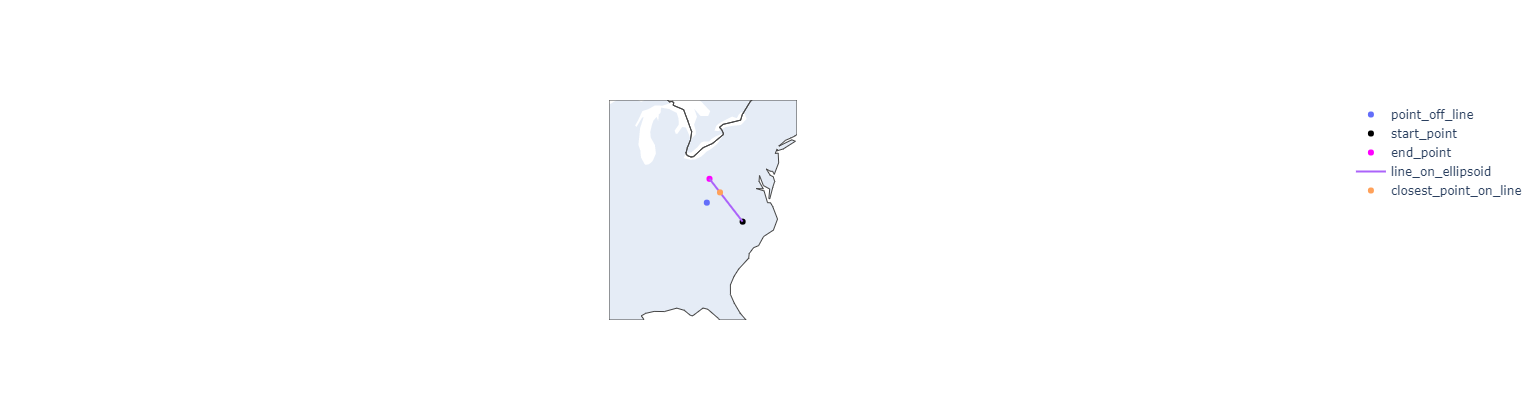

In [64]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

### Side Of Line Algorithm

So looking at the last figure, we can ask the important question: to which side of the line is `point_off_line`? LEFT or RIGHT?

In [65]:
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

def side_of_line(geodesic_crs_ned_deg=None, lat_lon_point_off_line_deg:tuple=None, closest_point_on_line_deg:tuple=None):
    print('FIXME: I dont think this transform is correct!')
    c_vector = pyproj.transform(lla, ecef, lat_lon_point_off_line_deg[1], lat_lon_point_off_line_deg[0], 0, radians=False)
    print(f'c_vector: {c_vector}')
    d_vector = pyproj.transform(lla, ecef, closest_point_on_line_deg[1], closest_point_on_line_deg[0], 0, radians=False)
    print(f'd_vector: {d_vector}')
    v_vector = np.cross(d_vector, c_vector)
    print(f'v_vector: {v_vector}')
    v_vector_unit = v_vector/np.linalg.norm(v_vector)
    print(f'{v_vector_unit}')
    
    side_as_string = 'NONE'
    angular_tolerance_deg = 5
    is_westerly = abs(geodesic_crs_ned_deg-270) < angular_tolerance_deg
    is_easterly = abs(geodesic_crs_ned_deg-90) < angular_tolerance_deg
    if is_easterly:
        if v_vector_unit[0] > 0:
            side_as_string = 'LEFT'
        else:
            side_as_string = 'RIGHT'
    if is_westerly:
        if v_vector_unit[0] < 0:
            side_as_string = 'RIGHT'
        else:
            side_as_string = 'LEFT'
    if geodesic_crs_ned_deg < 90 or geodesic_crs_ned_deg > 270:
        if v_vector_unit[2] > 0:
            side_as_string = 'LEFT'
        else:
            side_as_string = 'RIGHT'
    if geodesic_crs_ned_deg > 90 and geodesic_crs_ned_deg < 270:
        if v_vector_unit[2] < 0:
            side_as_string = 'LEFT'
        else:
            side_as_string = 'RIGHT'

    return side_as_string

In [66]:
expected_side = 'LEFT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

FIXME: I dont think this transform is correct!
c_vector: (701796.9898499511, 548303.9008954476, -6294478.015756379)
d_vector: (822813.0138708523, 656217.2822797972, -6269615.026959051)
v_vector: [-6.92890880e+11  7.79181473e+11 -9.37972818e+09]
[-0.66448969  0.74724329 -0.00899526]
The point is on the "RIGHT" side of the line; expected LEFT.


/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



In [67]:
# just in case debug plotting is turned on, turn it off for the rest of this notebook
debug_plots = False

## East Line

Let's try again with a line pointing east.

In [68]:
course_ned_deg = 89

In [69]:
start_point_deg = (-83.0, 37)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

(-81.9914108791244, 37.009833515870554)


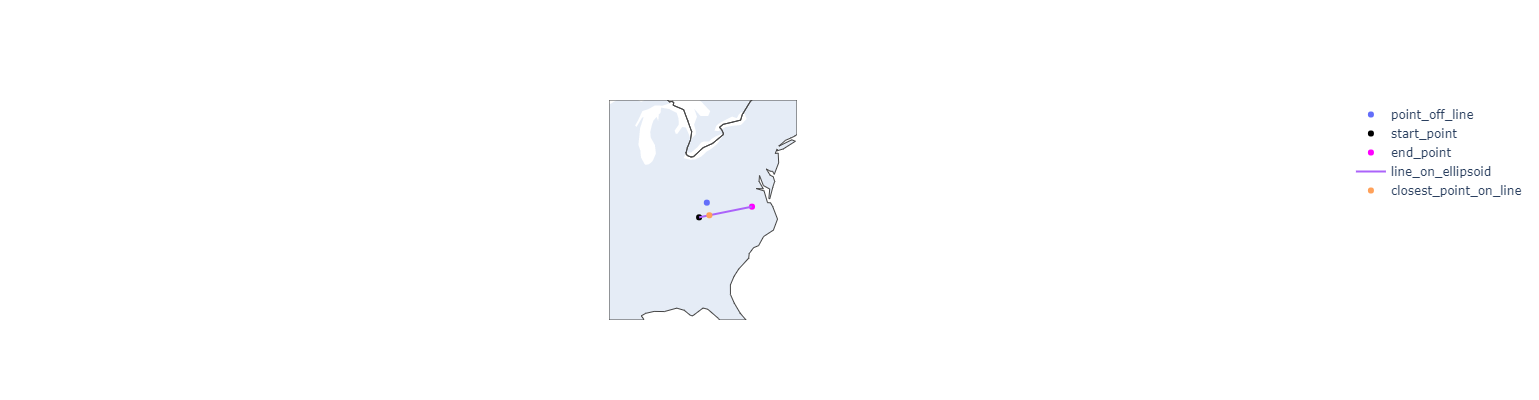

In [70]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [71]:
expected_side = 'LEFT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

FIXME: I dont think this transform is correct!
c_vector: (701796.9898499511, 548303.9008954476, -6294478.015756379)
d_vector: (711925.7896671015, 536666.1552737274, -6294344.4545855)
v_vector: [7.31803019e+10 6.38492406e+10 1.37209953e+10]
[0.74610304 0.65096906 0.13989115]
The point is on the "LEFT" side of the line; expected LEFT.


/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



## West Line

And again with a line pointing west.

In [72]:
course_ned_deg = 269

In [73]:
start_point_deg = (-78, 37)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

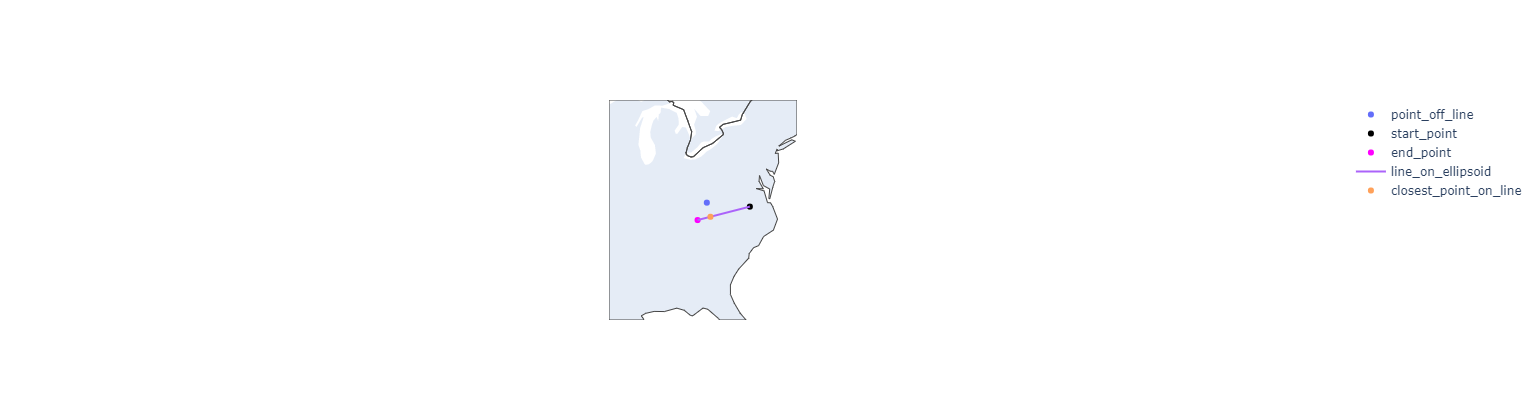

In [74]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [75]:
expected_side = 'RIGHT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

FIXME: I dont think this transform is correct!
c_vector: (701796.9898499511, 548303.9008954476, -6294478.015756379)
d_vector: (719710.8119853473, 539989.4362263263, -6293182.606977844)
v_vector: [5.16249374e+10 1.13667274e+11 1.56572848e+10]
[0.41030968 0.90341576 0.12444248]
The point is on the "RIGHT" side of the line; expected RIGHT.


/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



## Geodesics in Other Directions

What about other quadrants? Starting with south-west...

In [76]:
course_ned_deg = 225

In [77]:
start_point_deg = (-77.0, 37)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

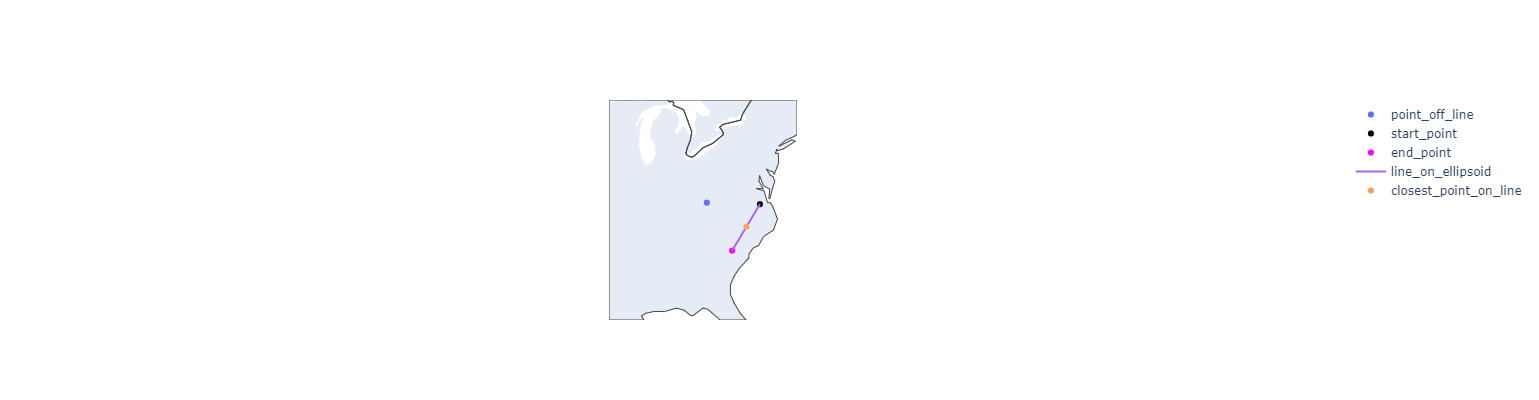

In [78]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [79]:
expected_side = 'RIGHT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

FIXME: I dont think this transform is correct!
c_vector: (701796.9898499511, 548303.9008954476, -6294478.015756379)


/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



d_vector: (1015809.8755817947, 726167.3050733459, -6233742.786458979)
v_vector: [-1.15285865e+12  2.01917101e+12  4.73504885e+10]
[-0.49572703  0.86823969  0.02036062]
The point is on the "RIGHT" side of the line; expected RIGHT.


And now let's do north-east...

In [80]:
course_ned_deg = 70

In [81]:
start_point_deg = (-85.0, 40)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

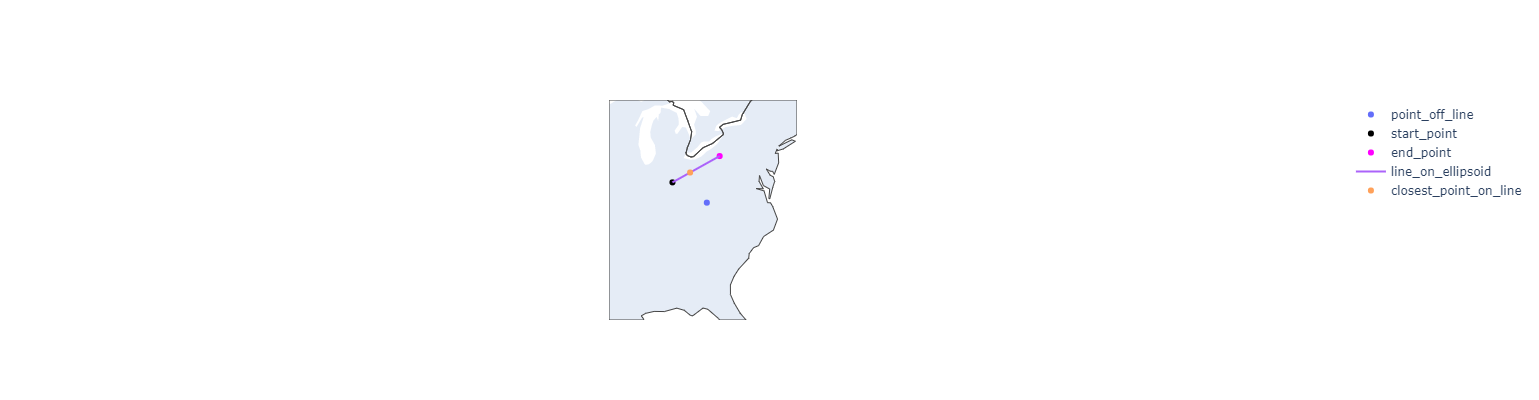

In [82]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [83]:
expected_side = 'RIGHT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

FIXME: I dont think this transform is correct!
c_vector: (701796.9898499511, 548303.9008954476, -6294478.015756379)
d_vector: (586261.9605499188, 501031.8889889178, -6310114.526182273)
v_vector: [ 3.06126199e+11 -7.38206358e+11 -3.01729516e+10]
[ 0.38278568 -0.92306644 -0.0377288 ]
The point is on the "RIGHT" side of the line; expected RIGHT.


/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

